<a href="https://colab.research.google.com/github/Dev2104/data-science/blob/main/Data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Libraries imported successfully.
Loading data from: /content/Confectionary_converted.csv
Data loaded successfully 
         Date Country(UK) Confectionary  Units Sold  Cost(£)  Profit(£)  \
0  11-11-2002     England       Biscuit      1118.0   2459.6     3130.4   
1  05-07-2002     England       Biscuit       708.0   1557.6     1982.4   
2  31-10-2001     England       Biscuit      1269.0   2791.8     3553.2   
3  13-09-2004     England       Biscuit      1631.0   3588.2     4566.8   
4  10-03-2004     England       Biscuit      2240.0   4928.0     6272.0   

   Revenue(£)  
0    749954.4  
1    300758.4  
2    966216.6  
3   1596096.6  
4   3010560.0  
-- - Cleaning data... ---
-- - Data cleaning complete ---
Cleaned Confectionary Types: ['Biscuit' 'Biscuit Nut' 'Chocolate Chunk' 'Caramel Nut' 'Caramel' 'Plain']
Cleaned Country Types: ['England' 'Scotland' 'Wales' 'N. Ireland' 'Jersey']

Imputing missing values and converting types... 
Missing values BEFORE imputation:
Units_Sold    5

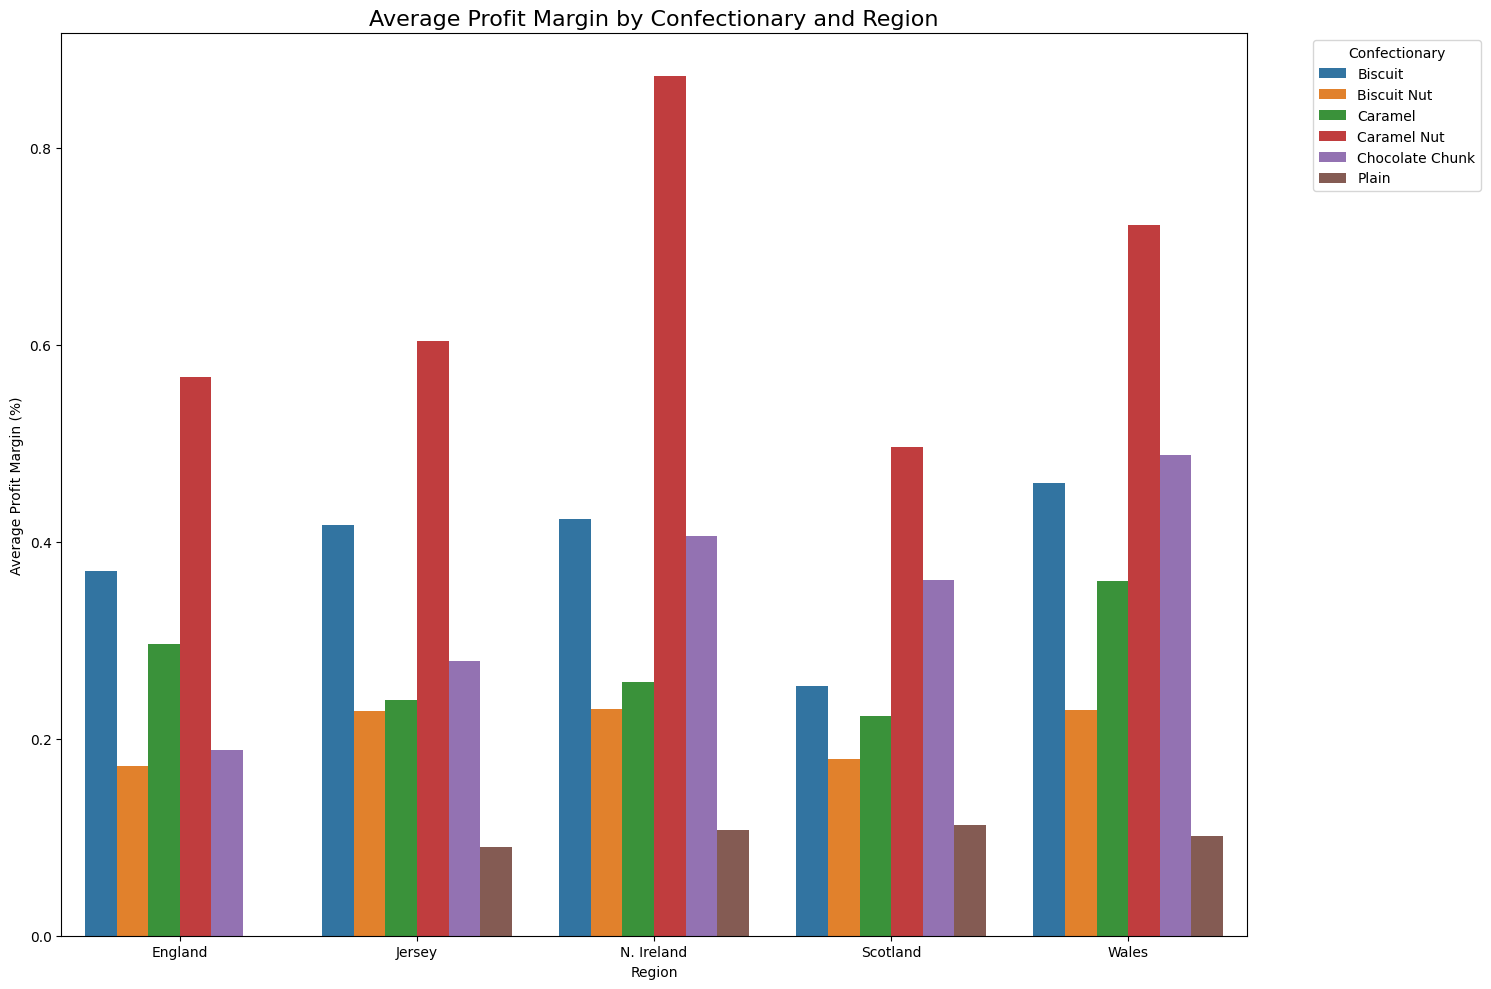


ANALYSIS: Sales Peaks Over Time (with Rolling Average)
Generating Sales Revenue line chart (Raw and Smoothed)...


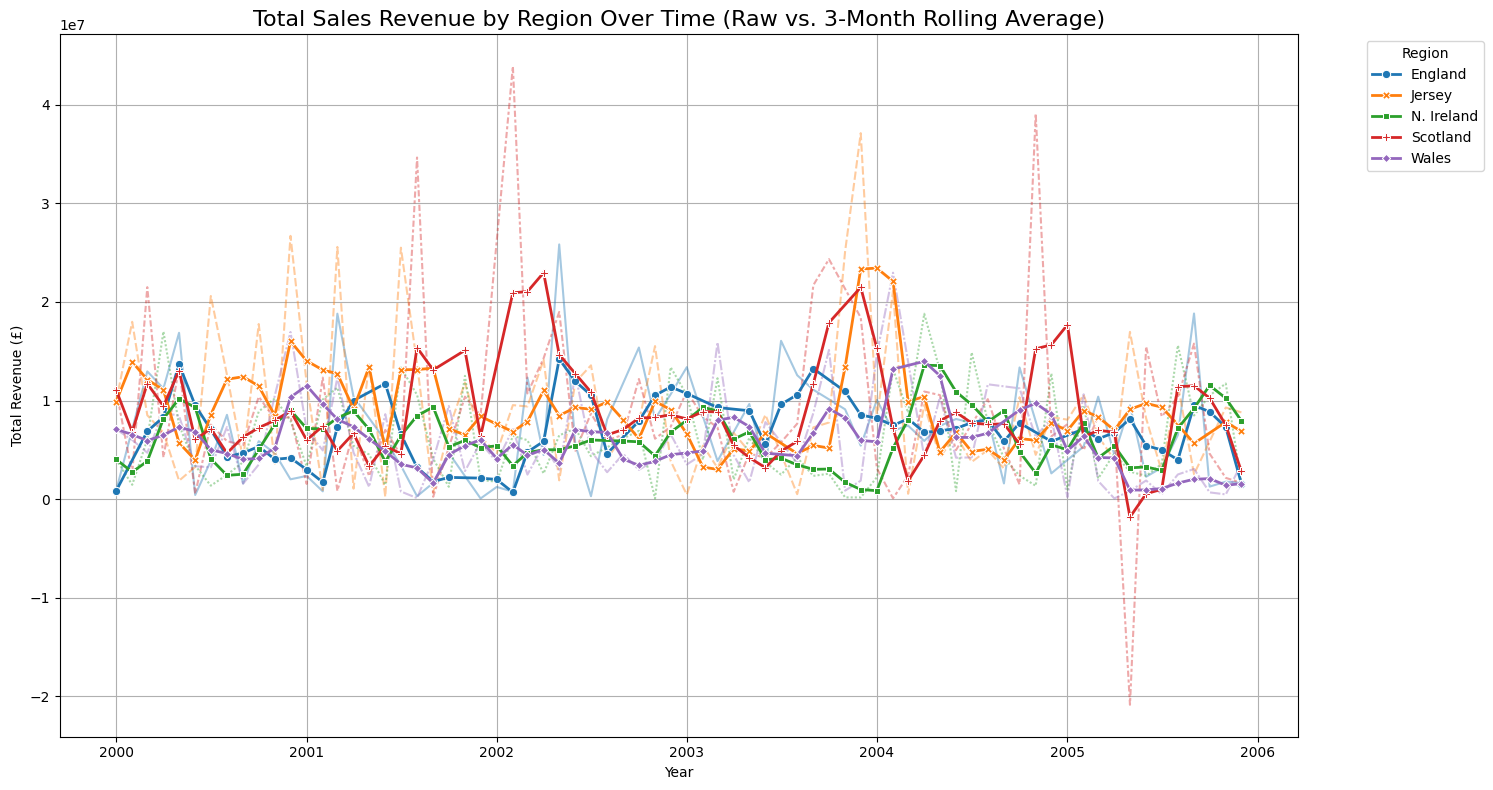


From the plot, the smoothed lines (solid, thicker) show clearer trends compared to the raw data (dashed, thinner).
'England' still shows the highest sales peaks consistently.

 Creating Dashboard-Style Plot (Static) 



 Analysis Complete


In [5]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import SimpleImputer
import plotly.express as px


print("Libraries imported successfully.")



file_path = "/content/Confectionary_converted.csv"
print(f"Loading data from: {file_path}")

# Read the file directly into a pandas DataFrame
df = pd.read_csv(file_path)
print("Data loaded successfully ")
print(df.head())




print("-- - Cleaning data... ---")

# 1. Clean column names (e.g., 'Country(UK)' -> 'Country')
# This standardizes the column names based on the file's content
df.columns = ['Date', 'Country', 'Confectionary', 'Units_Sold', 'Cost', 'Profit', 'Revenue']

# 2. Standardize 'Country' and 'Confectionary' text
# Remove newlines and extra spaces
df['Country'] = df['Country'].str.replace('N.\n Ireland', 'N. Ireland').str.strip()
df['Confectionary'] = df['Confectionary'].str.replace('\n', '').str.strip()

# Fix inconsistent spellings (as seen in the data)
df['Confectionary'] = df['Confectionary'].str.replace('Choclate Chunk', 'Chocolate Chunk')
df['Confectionary'] = df['Confectionary'].str.replace('Caramel nut', 'Caramel Nut', case=False)

print("-- - Data cleaning complete ---")
print("Cleaned Confectionary Types:", df['Confectionary'].unique())
print("Cleaned Country Types:", df['Country'].unique())




print("\nImputing missing values and converting types... ")

# 1. Impute missing numerical data using the median
numerical_cols = ['Units_Sold', 'Cost', 'Profit']
print("Missing values BEFORE imputation:")
print(df[numerical_cols].isnull().sum())

# Create the imputer
imputer = SimpleImputer(strategy='median')

# Fit and transform the data
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

print("\nMissing values AFTER imputation:")
print(df[numerical_cols].isnull().sum())

# 2. Convert 'Date' column to datetime objects
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')

print("\nData types converted ")
print(df.info())



print("\n-- - Creating 'Profit_Margin' and time-based columns... ---")


df['Profit_Margin'] = np.where(df['Revenue'] > 0, (df['Profit'] / df['Revenue']) * 100, 0)

# 2. Extract time features for sales peak analysis (CEO's request)
df['Year'] = df['Date'].dt.year
df['Month_Year'] = df['Date'].dt.to_period('M')

print("-- - Feature engineering complete ---")
print(df[['Date', 'Profit_Margin', 'Month_Year']].head())




print("\nANALYSIS: Largest & Smallest Profit Margins by Region")

# Group by Country and Confectionary, calculate mean profit margin
regional_margins = df.groupby(['Country', 'Confectionary'])['Profit_Margin'].mean().reset_index()


for country in regional_margins['Country'].unique():
    country_data = regional_margins[regional_margins['Country'] == country]

    # Find largest profit margin
    largest_margin_idx = country_data['Profit_Margin'].idxmax()
    largest_margin = country_data.loc[largest_margin_idx]
    print(f"In {country}, LARGEST profit margin: {largest_margin['Confectionary']} ({largest_margin['Profit_Margin']:.2f}%)")

    # Find smallest profit margin
    smallest_margin_idx = country_data['Profit_Margin'].idxmin()
    smallest_margin = country_data.loc[smallest_margin_idx]
    print(f"In {country}, SMALLEST profit margin: {smallest_margin['Confectionary']} ({smallest_margin['Profit_Margin']:.2f}%)")

# --- Visualization for Profit Margins ---
print("\nGenerating Profit Margin bar chart...")
plt.figure(figsize=(15, 10))
sns.barplot(
    data=regional_margins,
    x='Country',
    y='Profit_Margin',
    hue='Confectionary'
)
plt.title('Average Profit Margin by Confectionary and Region', fontsize=16)
plt.ylabel('Average Profit Margin (%)')
plt.xlabel('Region')
plt.legend(title='Confectionary', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()




print("\nANALYSIS: Sales Peaks Over Time (with Rolling Average)")

# Group by Month_Year and Country, summing Revenue
time_sales = df.groupby(['Month_Year', 'Country'])['Revenue'].sum().reset_index()

# Converting 'Month_Year' (Period) to timestamp for plotting
time_sales['Date'] = time_sales['Month_Year'].dt.to_timestamp()

# Sort by Date for correct rolling average calculation
time_sales = time_sales.sort_values(by=['Country', 'Date'])

# Calculate a 3-month rolling average for Revenue within each country group
time_sales['Revenue_Smoothed'] = time_sales.groupby('Country')['Revenue'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())

# --- Visualization: Sales Peaks Over Time (Raw vs. Smoothed) ---
print("Generating Sales Revenue line chart (Raw and Smoothed)...")
plt.figure(figsize=(15, 8))

# Plot raw revenue
sns.lineplot(
    data=time_sales,
    x='Date',
    y='Revenue',
    hue='Country',
    style='Country',
    markers=False,
    dashes=True,
    alpha=0.4,
    legend=False
)


sns.lineplot(
    data=time_sales,
    x='Date',
    y='Revenue_Smoothed',
    hue='Country',
    style='Country',
    markers=True,
    dashes=False,
    linewidth=2
)

plt.title('Total Sales Revenue by Region Over Time (Raw vs. 3-Month Rolling Average)', fontsize=16)
plt.ylabel('Total Revenue (£)')
plt.xlabel('Year')
plt.grid(True)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
print("""
From the plot, the smoothed lines (solid, thicker) show clearer trends compared to the raw data (dashed, thinner).
'England' still shows the highest sales peaks consistently.""")


# === Cell 8: Dashboard-Style Plot (Static) ===

print("\n Creating Dashboard-Style Plot (Static) ")


fig = px.bar(
    regional_margins,
    x='Confectionary',
    y='Profit_Margin',
    color='Confectionary',
    facet_col='Country',
    facet_col_wrap=3,
    title='Average Profit Margin by Confectionary and Region',
    labels={'Profit_Margin': 'Average Profit Margin (%)'}
)

# Displaying the plot
fig.show()

print("\n Analysis Complete")